In [1848]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [1770]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning) # FutureWarning 제거

In [1771]:
# 국회의원 298명에 대한 정보를 담고 있는 member df, node가 될 예정
member = pd.read_excel('./raw_data/member_of_Congress.xlsx')
member.head(1)

,이름,한자명,영문명칭,음/양력,생년월일,정당명,선거구,대표 위원회,재선,당선,...,이메일,홈페이지,보좌관,비서관,비서,재직구분,직업,학력,경력,득표수
0,강기윤,姜起潤,KANG GIYUN,양,1960-06-04,국민의힘,경남 창원시성산구,보건복지위원회,재선,"제19대, 제21대",...,ggotop@naver.com,http://blog.naver.com/ggotop,한영애,"김샛별, 장원종","안효상, 빈자영, 이유진, 김지훈, 조옥자",60001,정당인,창원대학교 대학원 졸업(행정학 박사),(전)19대 국회의원\n(현)미래통합당 경남도당 민생위원회 위원장,"61,782\n(47.30)"


In [1772]:
# member df 전처리 과정
member.loc[member['이름'] == '양원영', ['이름']] = '양이원영' # 이름 오류 수정
member['이름'] = member['이름'] + '(' + member['한자명'] + ')' # primary key인 이름(한자) 생성
member.sort_values(by = '이름', inplace = True) # 동명이인의 한자명에 따른 정렬 순서 이상 때문에 정렬 한 번
member.reset_index(drop = True, inplace = True) # 정렬에 따른 인덱스 이상 때문에 인덱스 정렬 한 번
member = member[['이름','정당명','생년월일','재선','소속 위원회 목록','성별','학력']]
member.head(3) # 필요 없는 데이터 잠깐 지우겠슴다

,이름,정당명,생년월일,재선,소속 위원회 목록,성별,학력
0,강기윤(姜起潤),국민의힘,1960-06-04,재선,보건복지위원회,남,창원대학교 대학원 졸업(행정학 박사)
1,강대식(姜大植),국민의힘,1959-11-02,초선,국토교통위원회,남,영남대학교 대학원 경영학과 졸업(경영학박사)
2,강득구(姜得求),더불어민주당,1963-05-27,초선,"인구위기특별위원회, 교육위원회",남,연세대학교 행정대학원 졸업(행정학석사)


In [1773]:
# 정당별 색상 매핑을 설정합니다.
party_colors = {
    '국민의힘': 'green',
    '더불어민주당': 'blue',
    '진보당':'red',
    '정의당': 'yellow',
    '무소속': "grey",
    '한국의희망':'navy',
    '기본소득당':'#98FF98',
    '시대전환':"#800080"
}

# 원본 member 데이터프레임에 'party_color' 컬럼을 추가합니다.
member['당색'] = member['정당명'].map(party_colors)
member['당색'].fillna('#000000')
print(member['당색'].value_counts())

blue       168
green      111
grey         9
yellow       6
red          1
navy         1
#98FF98      1
#800080      1
Name: 당색, dtype: int64


In [1774]:
# 그래프에서 feature로 활용하기 위해 당선횟수를 숫자로
member.rename(columns = {'재선' : '당선'}, inplace = True)
member['당선'] = member['당선'].str.replace('초', '1')
member['당선'] = member['당선'].str.replace('재', '2')
member['당선'] = member['당선'].str.replace('선', '')
member['당선'] = member['당선'].apply(pd.to_numeric)
member['당선'].value_counts()

1    155
2     69
3     41
4     20
5     12
6      1
Name: 당선, dtype: int64

In [1775]:
# 그래프에서 feature로 활용하기 위해 생년월일 to 나이
from datetime import datetime

member['생년월일'] = member['생년월일'].str.replace('-', '')
member['생년월일'] = pd.to_numeric(member['생년월일'])
today = int(datetime.now().strftime("%Y%m%d"))
member['생년월일'] = (today - member['생년월일'])//10000
member.rename(columns = {'생년월일' : '나이'}, inplace = True)
member.head(3)

,이름,정당명,나이,당선,소속 위원회 목록,성별,학력,당색
0,강기윤(姜起潤),국민의힘,63,2,보건복지위원회,남,창원대학교 대학원 졸업(행정학 박사),green
1,강대식(姜大植),국민의힘,64,1,국토교통위원회,남,영남대학교 대학원 경영학과 졸업(경영학박사),green
2,강득구(姜得求),더불어민주당,60,1,"인구위기특별위원회, 교육위원회",남,연세대학교 행정대학원 졸업(행정학석사),blue


In [1776]:
# 그래프에서 feature로 활용하기 위해 학력 표준화
arr = []
for edu in member['학력']:
  edu = str(edu)
  if '박사' in edu and '수료' in edu:
    arr.append(2)
  elif '박사' in edu:
    arr.append(3)
  elif '수료' in edu and '석사' in edu:
    arr.append(1)
  elif '석사' in edu:
    arr.append(2)
  elif '중퇴' in edu or '고등학교' in edu:
    arr.append(0)
  else:
    arr.append(1)

member['학력'] = arr
member['학력'] = pd.to_numeric(member['학력'])
member['학력'].value_counts()

1    128
2    102
3     66
0      2
Name: 학력, dtype: int64

In [1777]:
com_temp = member['소속 위원회 목록'].copy()

idx_temp = com_temp[com_temp.isna()].index[0]
for i in range(len(com_temp)):
    if i != idx_temp:
        member.loc[i, '위원회수'] = int(com_temp.loc[i].count(',')) + 1
member.loc[idx_temp, '위원회수'] = 0
member['위원회수'] = member['위원회수'].astype('int')
member['위원회수'].value_counts()

1    138
2     99
3     47
4     12
6      1
0      1
Name: 위원회수, dtype: int64

In [1778]:
# 가장 문제인 법안을 함께 작업한 국회의원 state
relation_raw = pd.read_csv('./raw_data/scraped_data_3.csv')
relation_raw.head(3)

,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,이용우,더불어민주당,李龍雨,9771184
0,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,강훈식,더불어민주당,姜勳植,9771007.0
1,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,김상희,더불어민주당,金相姬,9770527.0
2,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,김한규,더불어민주당,金翰奎,9771296.0


In [1779]:
# 컬럼명이 없어서 전처리
tmp1 = ['법안 ID','이름','정당명','한자명','번호']
tmp2 = list(relation_raw.columns)
tmp3 = pd.DataFrame([tmp2], columns = tmp1)
relation_raw.columns = tmp3.columns.copy()
relation = pd.concat([tmp3, relation_raw], axis = 0)
relation.reset_index(drop = True, inplace = True)
relation.dropna(subset = ['이름','한자명'], inplace = True) # 이름이 없는 데이터는 살릴 수 없어 과감히 drop
relation.head(3)

,법안 ID,이름,정당명,한자명,번호
0,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,이용우,더불어민주당,李龍雨,9771184
1,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,강훈식,더불어민주당,姜勳植,9771007.0
2,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,김상희,더불어민주당,金相姬,9770527.0


In [1780]:
# primary key인 이름(한자) 생성
relation['이름'] = relation['이름'] + '(' + relation['한자명'] + ')'
relation.drop(columns = ['한자명'], inplace = True)
relation.drop_duplicates(inplace = True) # 중복 데이터를 제거
relation.head(3)

,법안 ID,이름,정당명,번호
0,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,이용우(李龍雨),더불어민주당,9771184
1,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,강훈식(姜勳植),더불어민주당,9771007.0
2,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,김상희(金相姬),더불어민주당,9770527.0


In [1781]:
# relation에는 지금은 없는 의원과 이름이 잘못된 의원이 존재
name_arr1 = sorted(relation['이름'].unique())
name_arr2 = sorted(list(member['이름'].copy()))
name_arr3 = []
for i in name_arr1:
  if i not in name_arr2:
    name_arr3.append(i)
print(f'법안의 의원 명수: {len(name_arr1)}. 실제 의원 명수: {len(name_arr2)}. 법안에 있는 의원이 아닌 사람 수: {len(name_arr3)}')

법안의 의원 명수: 323. 실제 의원 명수: 298. 법안에 있는 의원이 아닌 사람 수: 26


In [1782]:
# 이름 고쳐줄 의원들 딕셔너리
mem_dict = {}
for i in name_arr2:
  for j in name_arr3:
    if i[0:3] == j[0:3]:
      mem_dict[j] = i
print(mem_dict, sep = ' ')

{'고민정(IOUAiO)': '고민정(高旼廷)', '고용진(高榕진)': '고용진(高榕禛)', '김종민(金鍾民)': '김종민(金鐘民)', '박정하(朴正何)': '박정하(朴正河)', '심상정(沈相정)': '심상정(沈相奵)', '이종성(李鐘成)': '이종성(李鍾成)', '지성호(地成浩)': '지성호(池成浩)'}


In [1783]:
ban_list = [] # 지금은 없어서 제거해줄 의원들 리스트
for i in name_arr3:
  if i not in mem_dict:
    ban_list.append(i)
print(ban_list, sep = ' ')

['곽상도(郭尙道)', '김선교(金善敎)', '김은혜(金恩慧)', '김진애(金鎭愛)', '김태흠(金泰欽)', '박완수(朴完洙)', '송영길(宋永吉)', '오영훈(吳怜勳)', '윤희숙(尹喜淑)', '이광재(李光宰)', '이규민(李圭閔)', '이낙연(李洛淵)', '이상직(李相稷)', '이영(李永)', '정정순(鄭正淳)', '정찬민(鄭燦敏)', '조태용(趙太庸)', '최강욱(崔康旭)', '홍준표(洪準杓)']


In [1784]:
relation.reset_index(inplace = True, drop = True)
for i in range(len(relation)): # 이름 잘못된 거 처리
  if relation['이름'][i] in mem_dict:
      relation['이름'][i] = mem_dict[relation['이름'][i]]
relation['이름'].value_counts()

오영환(吳永煥)    3095
양정숙(梁貞淑)    2926
김정호(金禎鎬)    2826
김병욱(金炳旭)    2820
            ... 
박병석(朴炳錫)      89
이재명(李在明)      87
강성희(姜聖熙)      48
허숙정(許淑湞)       9
Name: 이름, Length: 316, dtype: int64

In [1785]:
relation.set_index('이름', inplace = True) # 인덱스로 처리하면 속도가 빠르다
relation.drop(ban_list, axis = 0, inplace = True) # 없는 의원들 제거
relation.reset_index(inplace = True)
relation['이름'].value_counts()

오영환(吳永煥)    3095
양정숙(梁貞淑)    2926
김정호(金禎鎬)    2826
김병욱(金炳旭)    2820
            ... 
박병석(朴炳錫)      89
이재명(李在明)      87
강성희(姜聖熙)      48
허숙정(許淑湞)       9
Name: 이름, Length: 297, dtype: int64

In [1786]:
relation.set_index('이름', inplace = True)
for i in member['이름']:
    if len(relation.loc[i]['정당명'].unique()) != 1:
        print(i, end = ' ')

강기윤(姜起潤) 강대식(姜大植) 강민국(姜旻局) 강민정(姜旼姃) 구자근(具滋根) 권명호(權明浩) 권성동(權性東) 권영세(權寧世) 권은희(權垠希) 김기현(金起炫) 김남국(金南局) 김도읍(金度邑) 김미애(金美愛) 김병욱(金炳旭) 김병욱(金炳旭) 김상훈(金相勳) 김석기(金碩基) 김성원(金成願) 김승수(金承洙) 김영식(金英植) 김예지(金睿智) 김용판(金用判) 김웅(金雄) 김의겸(金宜謙) 김정재(金汀才) 김진표(金振杓) 김태호(金台鎬) 김형동(金亨東) 김홍걸(金弘傑) 김희곤(金熙坤) 김희국(金熙國) 류성걸(柳性杰) 민형배(閔馨培) 박대수(朴大壽) 박대출(朴大出) 박덕흠(朴德欽) 박병석(朴炳錫) 박성민(朴聖敏) 박성중(朴成重) 박수영(朴洙瑩) 박완주(朴完柱) 박진(朴振) 박형수(朴亨修) 배준영(裵俊英) 배현진(裵賢鎭) 백종헌(白宗憲) 서범수(徐範洙) 서병수(徐秉洙) 서일준(徐一俊) 서정숙(徐正淑) 성일종(成一鍾) 송석준(宋錫俊) 송언석(宋彦錫) 신원식(申源湜) 안병길(安炳吉) 양금희(梁琴喜) 양이원영(梁李媛瑛) 양향자(梁香子) 엄태영(嚴泰永) 유경준(兪京濬) 유상범(劉相凡) 유의동(兪義東) 윤관석(尹官石) 윤두현(尹斗鉉) 윤미향(尹美香) 윤상현(尹相現) 윤영석(尹永碩) 윤재옥(尹在玉) 윤주경(尹柱卿) 윤창현(尹暢賢) 윤한홍(尹漢洪) 이달곤(李達坤) 이만희(李晩熙) 이명수(李明洙) 이성만(李成萬) 이양수(李亮壽) 이용(李鏞) 이용호(李容鎬) 이종배(李鍾培) 이종성(李鍾成) 이주환(李周桓) 이채익(李埰益) 이철규(李喆圭) 이태규(李泰珪) 이헌승(李憲昇) 임병헌(林炳憲) 임이자(林利子) 장제원(張濟元) 전봉민(田奉珉) 전주혜(全珠惠) 정경희(丁慶姬) 정동만(鄭東萬) 정운천(鄭雲天) 정점식(鄭点植) 정진석(鄭鎭碩) 정희용(鄭熙溶) 조경태(趙慶泰) 조명희(曺明姬) 조수진(趙修眞) 조해진(曺海珍) 주호영(朱豪英) 지성호(池成浩) 최승재(崔承宰) 최연숙(崔姸淑) 최춘식(崔春植) 최형두(崔炯斗) 추경호(秋慶鎬) 태영호(太永浩) 하영제(河榮帝) 하태경(河泰慶) 한기호(韓起鎬) 한무경(韓

In [1787]:
member[member['이름'].duplicated(keep = False)]

,이름,정당명,나이,당선,소속 위원회 목록,성별,학력,당색,위원회수
34,김병욱(金炳旭),더불어민주당,58,2,"국토교통위원회, 예산결산특별위원회",남,2,blue,2
35,김병욱(金炳旭),국민의힘,46,1,과학기술정보방송통신위원회,남,2,green,1


In [1788]:
idx_temp = member[member['이름'].duplicated(keep = False)].index
name_temp1 = member.loc[idx_temp[0], '이름']
member.loc[idx_temp[0], '이름'] = name_temp1[0:3] + 'A' + name_temp1[3:]
name_temp1 = member.loc[idx_temp[1], '이름']
member.loc[idx_temp[1], '이름'] = name_temp1[0:3] + 'B' + name_temp1[3:]
member.loc[idx_temp]

,이름,정당명,나이,당선,소속 위원회 목록,성별,학력,당색,위원회수
34,김병욱A(金炳旭),더불어민주당,58,2,"국토교통위원회, 예산결산특별위원회",남,2,blue,2
35,김병욱B(金炳旭),국민의힘,46,1,과학기술정보방송통신위원회,남,2,green,1


In [1789]:
relation.reset_index(inplace = True)
relation.loc[(relation['이름'] == '김병욱(金炳旭)') & (relation['정당명'] == '더불어민주당'), '이름'] = '김병욱A(金炳旭)'
relation.loc[(relation['이름'] == '김병욱(金炳旭)') & (relation['정당명'] == '무소속'), '정당명'] = '국민의힘'
relation.loc[(relation['이름'] == '김병욱(金炳旭)') & (relation['정당명'] == '미래통합당'), '정당명'] = '국민의힘'
relation.loc[(relation['이름'] == '김병욱(金炳旭)') & (relation['정당명'] == '국민의힘'), '이름'] = '김병욱B(金炳旭)'
relation.loc[relation['이름'] == '김병욱(金炳旭)'].head(3)

,이름,법안 ID,정당명,번호


In [1790]:
relation = relation.sort_values(by=['법안 ID','이름'], ascending = [True, True])
relation.set_index('이름', inplace = True)
for i in range(len(member)):
    relation.loc[member.loc[i, '이름'], '정당명'] = member.loc[i, '정당명']
relation.head(3)

,법안 ID,정당명,번호
이름,,,
구자근(具滋根),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9771224.0
김도읍(金度邑),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9770719.0
안병길(安炳吉),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9771132.0


In [1791]:
for i in member['이름']:
    if len(relation.loc[i]['정당명'].unique()) != 1:
        print(i, end = ' ')

In [1792]:
# 아직은 상태 feature만을 가져오기 위한 state
custom_column_names = ['제목','담당','날짜','임시','임시2','임시3','상태','계류','법안 ID']
state = pd.read_csv('./raw_data/scraped_data.csv', names = custom_column_names, skiprows = 1)
state.dropna(subset = ['상태'], inplace = True) # 상태가 없으면 쓸모가 없지요
state[state['상태'] == '본희의의결'] = '본회의의결'
state = state[state['담당'] == '의원']
state.head(3)

,제목,담당,날짜,임시,임시2,임시3,상태,계류,법안 ID
2125205,자본시장과 금융투자업에 관한 법률 일부개정법률안(이용우의원 등 11인),의원,2023-10-30,NaN,NaN,NaN,접수,계,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3
2125204,공유재산 및 물품 관리법 일부개정법률안(황희의원 등 12인),의원,2023-10-30,NaN,NaN,NaN,접수,계,PRC_O2T3B1B0Z2Z4F1E3C3Z9Y4H8G7F4M3
2125203,학교용지 확보 등에 관한 특례법 일부개정법률안(황희의원 등 12인),의원,2023-10-30,NaN,NaN,NaN,접수,계,PRC_Z2X3W1X0W2R4Q1Y3X4W1V3D3B6I0G7


In [1793]:
good = ['공포', '본회의의결', '수정안반영폐기', '대안반영폐기']
bad = ['폐기', '정부이송', '본회의불부의', '체계자구심사', '소관위심사', '소관위접수', '철회', '본회의부의안건', '접수']

def change_state(x) :
  if str(x) in good:
    return '가결'
  else:
    return '가결외'

state['상태'] = state['상태'].apply(change_state)
state['상태'].value_counts()

가결외    17148
가결      5823
Name: 상태, dtype: int64

In [1794]:
for i in state.index.unique():
    if not any(char.isdigit() for char in str(state.loc[i,'제목'])):
        state.drop(i, axis = 0, inplace = True)

In [1795]:
# join 해주기 위해 전처리
state_temp = state.loc[:, ['법안 ID','상태','제목']]
state_temp.reset_index(inplace = True)
state_temp.drop(columns = ['index'], inplace = True)
state_temp.head(3)

,법안 ID,상태,제목
0,PRC_M2L3N1N0M2L5J1S4Q3R7Q3O5W3V5U3,가결외,자본시장과 금융투자업에 관한 법률 일부개정법률안(이용우의원 등 11인)
1,PRC_O2T3B1B0Z2Z4F1E3C3Z9Y4H8G7F4M3,가결외,공유재산 및 물품 관리법 일부개정법률안(황희의원 등 12인)
2,PRC_Z2X3W1X0W2R4Q1Y3X4W1V3D3B6I0G7,가결외,학교용지 확보 등에 관한 특례법 일부개정법률안(황희의원 등 12인)


In [1796]:
# inner join
relation.reset_index(inplace = True)
relation_state = pd.merge(relation, state_temp, how = 'inner', on = '법안 ID')
relation_state.drop_duplicates(inplace = True) # 중복 데이터를 제거
relation_state.reset_index(drop = True, inplace = True)
relation_state['초당'] = -1
relation_state.head(3)

,이름,법안 ID,정당명,번호,상태,제목,초당
0,구자근(具滋根),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9771224.0,가결외,한국산업은행법 일부개정법률안(김도읍의원 등 10인),-1
1,김도읍(金度邑),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9770719.0,가결외,한국산업은행법 일부개정법률안(김도읍의원 등 10인),-1
2,안병길(安炳吉),PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,국민의힘,9771132.0,가결외,한국산업은행법 일부개정법률안(김도읍의원 등 10인),-1


In [1797]:
relation_state.set_index('법안 ID', inplace = True)
for i in relation_state.index.unique():
    if len(relation_state.loc[i, '정당명'].unique()) == 1:
        relation_state.loc[i, '초당'] = 0
    else:
        relation_state.loc[i, '초당'] = 1
relation_state['초당'].value_counts()

1    169359
0    138317
Name: 초당, dtype: int64

In [1798]:
relation_state.reset_index(inplace = True)
tm = pd.DataFrame(relation_state.groupby(['이름','상태','초당'])['법안 ID'].count())
tm.reset_index(inplace = True)
tm.head(3)

,이름,상태,초당,법안 ID
0,강기윤(姜起潤),가결,0,216
1,강기윤(姜起潤),가결,1,127
2,강기윤(姜起潤),가결외,0,617


In [1799]:
for i in member['이름']:
    if len(tm.loc[tm['이름'] == i]) != 4:
        df = pd.DataFrame({'이름':[i,i],'상태':['가결','가결외'],'초당':[0,0],'법안 ID':[0,0]})
        tm = tm.append(df,ignore_index=True)
tm = tm.sort_values(by = ['이름','상태','초당'])
tm = tm.drop(1190, axis = 0)
tm.set_index('이름', inplace = True)
tm.head(3)

,상태,초당,법안 ID
이름,,,
강기윤(姜起潤),가결,0,216
강기윤(姜起潤),가결,1,127
강기윤(姜起潤),가결외,0,617


In [1800]:
mem_law = pd.DataFrame(0, index = member['이름'].copy(),
                       columns = ['가결+초당','가결+비초당','가결외+초당','가결외+비초당'])
for i in member['이름'].copy():
    mem_law.loc[i, '가결+비초당'] = tm.loc[i, '법안 ID'][0]   
    mem_law.loc[i, '가결+초당'] = tm.loc[i, '법안 ID'][1]
    mem_law.loc[i, '가결외+비초당'] = tm.loc[i, '법안 ID'][2]
    mem_law.loc[i, '가결외+초당'] = tm.loc[i, '법안 ID'][3]
mem_law['가결'] = mem_law['가결+초당']+mem_law['가결+비초당']
mem_law['가결외'] = mem_law['가결외+초당']+mem_law['가결외+비초당']
mem_law['초당'] = mem_law['가결+초당']+mem_law['가결외+초당']
mem_law['비초당'] = mem_law['가결+비초당']+mem_law['가결외+비초당']
mem_law['법안'] = mem_law['가결+초당']+mem_law['가결외+초당']+mem_law['가결+비초당']+mem_law['가결외+비초당']
mem_law.reset_index(inplace = True)
mem_law.head(3)

,이름,가결+초당,가결+비초당,가결외+초당,가결외+비초당,가결,가결외,초당,비초당,법안
0,강기윤(姜起潤),127,216,276,617,343,893,403,833,1236
1,강대식(姜大植),157,149,296,431,306,727,453,580,1033
2,강득구(姜得求),285,102,696,497,387,1193,981,599,1580


In [1801]:
member = pd.merge(member, mem_law[['이름','가결','가결외','초당','비초당','법안']], how = 'inner', on = '이름')
member.head(3)

,이름,정당명,나이,당선,소속 위원회 목록,성별,학력,당색,위원회수,가결,가결외,초당,비초당,법안
0,강기윤(姜起潤),국민의힘,63,2,보건복지위원회,남,3,green,1,343,893,403,833,1236
1,강대식(姜大植),국민의힘,64,1,국토교통위원회,남,3,green,1,306,727,453,580,1033
2,강득구(姜得求),더불어민주당,60,1,"인구위기특별위원회, 교육위원회",남,2,blue,2,387,1193,981,599,1580


In [1802]:
num = len(member)
myArr = np.zeros((num*(num-1)//2, 4), dtype = int)
graph_edge = pd.DataFrame(myArr, columns = ['의원A', '의원B', '가결', '가결외'])
graph_edge.head(3)

,의원A,의원B,가결,가결외
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0


In [1803]:
# 파이썬스러운 날먹 방법이 분명 있을 것 같은데 생각이 안 난다...
graph_edge = graph_edge.astype({'의원A':'object', '의원B':'object'})
cnt = 0
for i in range(num):
  for j in range(i + 1, num):
    graph_edge.loc[cnt, '의원A'], graph_edge.loc[cnt,'의원B'] = member.loc[i, '이름'], member.loc[j,'이름']
    # df_graph에 의원 이름을 인덱스로 넣어주기
    cnt+=1
graph_edge.set_index(['의원A', '의원B'], inplace = True) # 속도를 위해 의원 이름을 index로
graph_edge.head(3)

가결  가결외
의원A      의원B              
강기윤(姜起潤) 강대식(姜大植)   0    0
         강득구(姜得求)   0    0
         강민국(姜旻局)   0    0

In [1804]:
idx = [0] # 한 법안의 index, idx[i]:idx[i+1]에는 같은 법안을 낸 여러 사람의 명단이 있다.
for i in range(len(relation_state)-1):
  if relation_state['법안 ID'][i] != relation_state['법안 ID'][i+1]:
    idx.append(i+1)
idx.append(len(relation_state))
print(idx, sep = ' ')

[0, 9, 21, 38, 48, 60, 70, 82, 98, 109, 119, 131, 140, 150, 160, 170, 179, 190, 201, 212, 222, 231, 244, 255, 268, 279, 290, 303, 314, 327, 338, 348, 365, 375, 385, 399, 422, 432, 446, 457, 469, 480, 490, 529, 539, 550, 561, 574, 585, 596, 605, 615, 624, 637, 667, 679, 689, 700, 711, 722, 731, 751, 762, 774, 783, 794, 804, 817, 827, 838, 854, 864, 875, 888, 898, 908, 952, 964, 976, 987, 1048, 1069, 1083, 1093, 1108, 1130, 1140, 1151, 1164, 1174, 1185, 1197, 1212, 1225, 1235, 1245, 1255, 1269, 1278, 1293, 1305, 1315, 1326, 1340, 1351, 1360, 1370, 1381, 1391, 1407, 1418, 1428, 1441, 1459, 1469, 1481, 1492, 1503, 1513, 1525, 1535, 1548, 1558, 1570, 1580, 1617, 1628, 1643, 1653, 1663, 1672, 1682, 1692, 1702, 1714, 1724, 1734, 1755, 1768, 1778, 1789, 1799, 1812, 1825, 1842, 1853, 1863, 1873, 1884, 1895, 1907, 1917, 1927, 1937, 1947, 1958, 1969, 1979, 1989, 2008, 2019, 2029, 2040, 2050, 2060, 2073, 2084, 2093, 2102, 2112, 2127, 2136, 2148, 2159, 2170, 2180, 2193, 2202, 2214, 2225, 2235, 2248

In [1805]:
for i in range(len(idx)-1):
    lst = relation_state['이름'][idx[i]:idx[i+1]].copy().reset_index(drop = True)
    for j in range(len(lst)-1):
        graph_edge.loc[(lst[j], lst[j+1:len(lst)]), [relation_state['상태'][idx[i]]]] += 1
graph_edge.head(3)

가결  가결외
의원A      의원B              
강기윤(姜起潤) 강대식(姜大植)  95   99
         강득구(姜得求)  53    6
         강민국(姜旻局)  71   54

In [1806]:
graph_edge['법안'] = graph_edge.loc[:][:].sum(axis = 1)
graph_edge.head(3)

가결  가결외   법안
의원A      의원B                   
강기윤(姜起潤) 강대식(姜大植)  95   99  194
         강득구(姜得求)  53    6   59
         강민국(姜旻局)  71   54  125

In [1807]:
party_dict = dict(zip(member['이름'], member['정당명']))
graph_edge.reset_index(inplace = True)
for i in range(len(graph_edge)):
    if party_dict[graph_edge.loc[i, '의원A']] == party_dict[graph_edge.loc[i, '의원B']]:
        graph_edge.loc[i,'초당'] = 0
    else:
        graph_edge.loc[i,'초당'] = 1
graph_edge['초당'] = graph_edge['초당'].astype(int)
graph_edge.head(3)

,의원A,의원B,가결,가결외,법안,초당
0,강기윤(姜起潤),강대식(姜大植),95,99,194,0
1,강기윤(姜起潤),강득구(姜得求),53,6,59,1
2,강기윤(姜起潤),강민국(姜旻局),71,54,125,0


In [1808]:
graph_edge.to_csv('./raw_data/graph_edge.csv')
graph_edge = pd.read_csv('./raw_data/graph_edge.csv')

In [1809]:
nx_G = nx.from_pandas_edgelist(graph_edge, source = '의원A', target = '의원B', create_using = nx.Graph())
nx_G

In [1810]:
nx_G.number_of_edges(), nx_G.number_of_nodes()

(44253, 298)

In [1811]:
age_dict = dict(zip(member['이름'], member['나이']))
party_dict = dict(zip(member['이름'], member['정당명']))
num_dict = dict(zip(member['이름'], member['당선']))
gender_dict = dict(zip(member['이름'], member['성별']))
edu_dict = dict(zip(member['이름'], member['학력']))
committee_dict = dict(zip(member['이름'], member['위원회수']))
passed_dict = dict(zip(member['이름'], member['가결']))
rejected_dict = dict(zip(member['이름'], member['가결외']))
cho_dict = dict(zip(member['이름'], member['초당']))
notcho_dict = dict(zip(member['이름'], member['비초당']))
total_dict = dict(zip(member['이름'], member['법안']))

In [1812]:
nx.set_node_attributes(nx_G, age_dict, '나이')
nx.set_node_attributes(nx_G, party_dict, '정당명')
nx.set_node_attributes(nx_G, num_dict, '당선')
nx.set_node_attributes(nx_G, gender_dict, '성별')
nx.set_node_attributes(nx_G, edu_dict, '학력')
nx.set_node_attributes(nx_G, committee_dict, '위원회수')
nx.set_node_attributes(nx_G, passed_dict, '가결')
nx.set_node_attributes(nx_G, rejected_dict, '가결외')
nx.set_node_attributes(nx_G, cho_dict, '초당')
nx.set_node_attributes(nx_G, notcho_dict, '비초당')
nx.set_node_attributes(nx_G, total_dict, '법안')

In [1813]:
nx_G.nodes['강기윤(姜起潤)']

{'나이': 63,
 '정당명': '국민의힘',
 '당선': 2,
 '성별': '남',
 '학력': 3,
 '위원회수': 1,
 '가결': 343,
 '가결외': 893,
 '초당': 403,
 '비초당': 833,
 '법안': 1236}

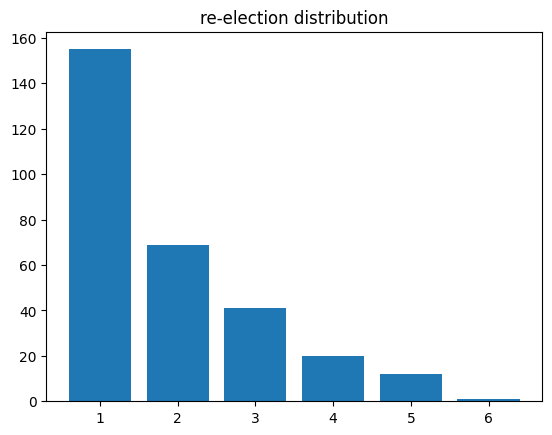

In [1814]:
# '당선' 컬럼의 값 분포를 카운트
value_counts = member['당선'].value_counts().sort_index()

# 분포를 막대 그래프로 시각화
plt.bar(value_counts.index, value_counts.values)

# 그래프 제목 및 축 라벨 설정
plt.title('re-election distribution')

# 그래프 표시
plt.show()

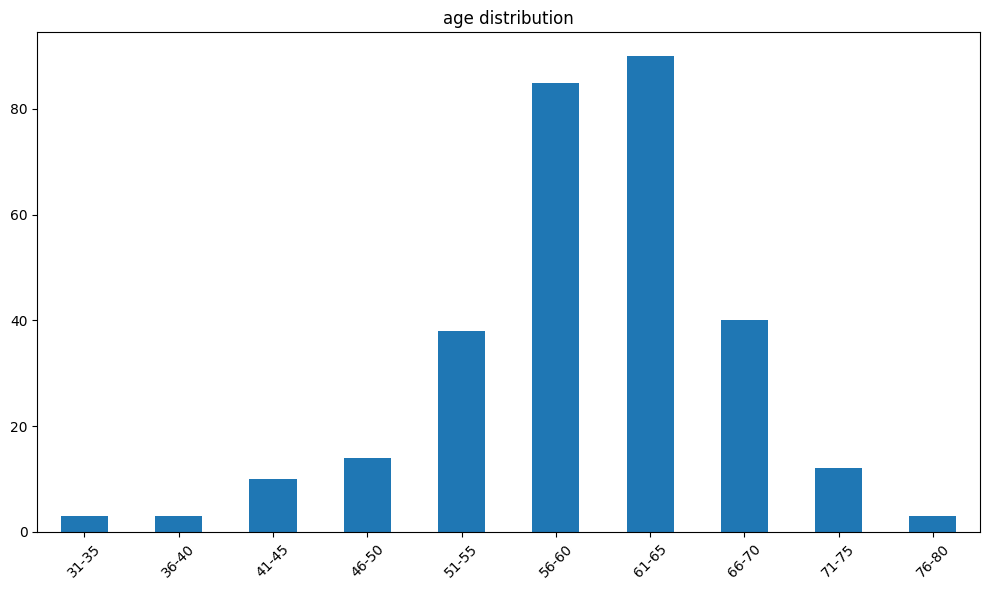

In [1815]:
age_bins = range((member['나이'].min()//5)*5, member['나이'].max() + 5, 5)  # 나이 최대값까지 5살 간격으로 bins 생성
age_labels = [f"{i+1}-{i+5}" for i in age_bins[:-1]]  # 라벨은 '1-5', '6-10', ...

# pd.cut을 사용하여 나이 구간을 생성
age_cut = pd.cut(member['나이'], bins=age_bins, labels=age_labels, right=False)

# 나이 구간별 빈도수 계산
age_distribution = age_cut.value_counts().sort_index()

# 분포를 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('age distribution')
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

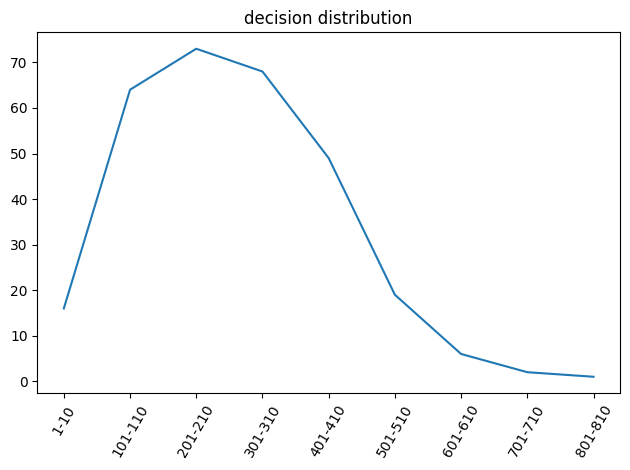

In [1816]:
decision_bins = range(int(member['가결'].min()//100*100), int(member['가결'].max()) + 100, 100)  # 의결안 수 최대값까지 구간 생성
decision_labels = [f"{i+1}-{i+10}" for i in decision_bins[:-1]]

# pd.cut을 사용하여 의결안 수 구간을 생성
decision_cut = pd.cut(member['가결'], bins=decision_bins, labels=decision_labels, right=False)

# 의결안 수 구간별 빈도수 계산
decision_distribution = decision_cut.value_counts().sort_index()

# 분포를 막대 그래프로 시각화
decision_distribution.plot(kind='line')
plt.title('decision distribution')
plt.xticks(rotation=60)  # x축 라벨 회전
plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()

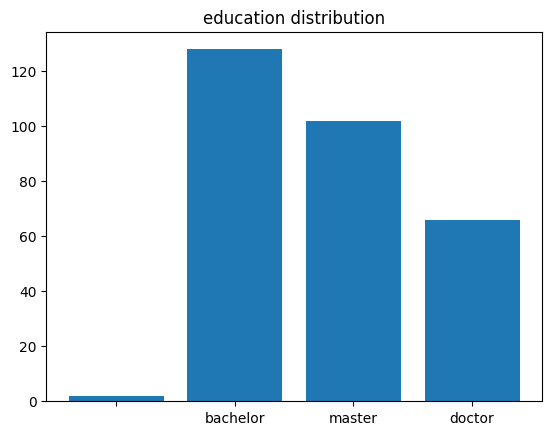

In [1817]:
# '학력' 컬럼의 값 분포를 카운트
value_counts = member['학력'].value_counts().sort_index()

# 분포를 막대 그래프로 시각화
bars = plt.bar(['고졸','학사','석사','박사'], value_counts.values, tick_label=['','bachelor','master','doctor'])

# 그래프 제목 및 축 라벨 설정
plt.title('education distribution')

# 그래프 표시
plt.show()

In [1818]:
value_counts = member['위원회수'].value_counts().sort_index()
value_counts

0      1
1    138
2     99
3     47
4     12
6      1
Name: 위원회수, dtype: int64

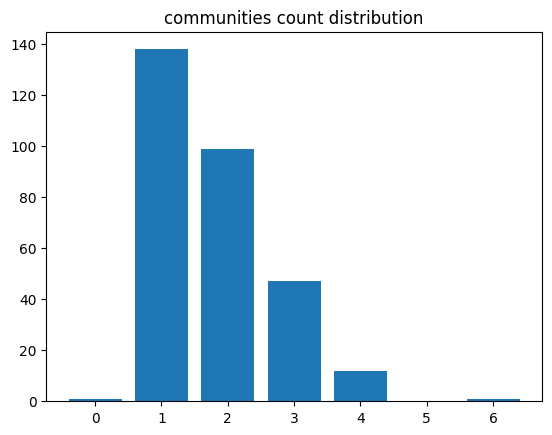

In [1819]:
# '소속 위원회 개수' 컬럼의 값 분포를 카운트
value_counts = member['위원회수'].value_counts().sort_index()

# 분포를 막대 그래프로 시각화
plt.bar(value_counts.index, value_counts.values)

# 그래프 제목 및 축 라벨 설정
plt.title('communities count distribution')

# 그래프 표시
plt.show()

1. top 10% 국회의원이 얼마나 전체 상호작용의 얼마에 참여하는가?

In [1820]:
# 상위 10% -> 20% / 하위 10% -> 3%
member.set_index('이름', inplace = True)
print(f"법안 개수 상위 10% 의원: 전체 법안의 {round(member['법안'].sort_values(ascending = False)[:30].sum() / member['법안'].sum()*100, 2)}%")
print(f"법안 개수 하위 10% 의원: 전체 법안의 {round(member['법안'].sort_values()[:30].sum() / member['법안'].sum()*100, 2)}%")

법안 개수 상위 10% 의원: 전체 법안의 20.34%
법안 개수 하위 10% 의원: 전체 법안의 2.93%


2. degree of separation?

In [1821]:
dos = sorted(list(graph_edge.법안.value_counts()))
print(dos, sep = ' ')
print('모든 의원이 서로 연결되어있으므로 이 그래프의 degree of separation은 1')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 26, 26, 27, 27, 27, 27, 27, 28, 28, 29, 29, 29, 29, 30, 30, 31, 31, 32, 32, 32, 33, 33, 33, 33, 33, 

3. 법안에 참여하는 의원 수 분포

In [1822]:
law = []
for i in range(len(idx)-1):
  law.append(idx[i+1]-idx[i])
print(sorted(law, reverse = True), end = ' ')

[281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 270, 270, 270, 263, 263, 263, 263, 263, 263, 263, 263, 263, 261, 261, 261, 261, 261, 261, 261, 261, 260, 260, 260, 260, 260, 186, 182, 182, 181, 181, 181, 181, 180, 177, 175, 174, 169, 169, 169, 169, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 166, 166, 166, 166, 166, 166, 165, 165, 165, 155, 146, 135, 135, 132, 132, 131, 129, 125, 125, 124, 124, 123, 122, 119, 117, 113, 113, 113, 113, 113, 111, 111, 107, 106, 106, 103, 103, 103, 102, 102, 100, 100, 100, 100, 99, 99, 99, 98, 98, 97, 97, 97, 95, 95, 95, 95, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 93, 93, 93, 92, 92, 88, 87, 85, 83, 82, 82, 81, 81, 81, 78, 77, 77, 74, 74, 73, 72, 72, 72, 70, 69, 69, 68, 68, 67, 66, 65, 65, 65, 65, 65, 65, 64, 62, 62, 62, 62, 61, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 60, 60, 59, 59, 59

In [1823]:
pd.Series(law).describe()

count    22924.000000
mean        13.421567
std         16.145488
min          6.000000
25%         10.000000
50%         11.000000
75%         13.000000
max        281.000000
dtype: float64

In [1824]:
np.percentile(law, [90, 95, 99]) # 특별히 많은 의원들이 참여한 소수의 법안이 존재

array([16.  , 21.  , 55.77])

4. 초당적 협력

In [1844]:
# member.reset_index(inplace = True)
tmp_df = pd.merge(member[['이름', '당선']], mem_law, how = 'inner', on = '이름')
tmp_df['가결률'] = tmp_df['가결'] / tmp_df['법안']
tmp_df['초당률'] = tmp_df['초당'] / tmp_df['법안']
tmp_df.head(3)

,이름,당선,가결+초당,가결+비초당,가결외+초당,가결외+비초당,가결,가결외,초당,비초당,법안,가결률,초당률
0,강기윤(姜起潤),2,127,216,276,617,343,893,403,833,1236,0.277508,0.326052
1,강대식(姜大植),1,157,149,296,431,306,727,453,580,1033,0.296225,0.438529
2,강득구(姜得求),1,285,102,696,497,387,1193,981,599,1580,0.244937,0.620886


<AxesSubplot: xlabel='당선'>

c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


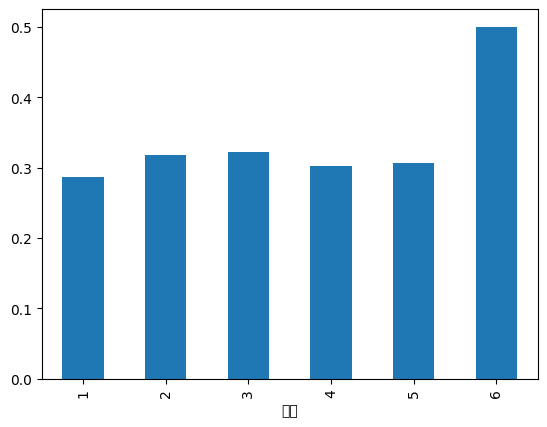

In [1845]:
tmp_df.groupby('당선')['가결률'].mean().plot.bar()

당선 횟수와 초당적 협력 빈도는 연관이 없다.

In [1846]:
tmp_df[['법안','초당률']].corr()

,법안,초당률
법안,1.00000,-0.07121
초당률,-0.07121,1.00000


제출한 법안 개수와 초당적 협력은 관련이 없다.

In [1858]:
rel = relation_state[['법안 ID','상태','초당']].copy()
rel = rel.drop_duplicates()
rel['국민의힘'] = 0
rel['더불어민주당'] = 0
rel['진보당'] = 0
rel['정의당'] = 0
rel['무소속'] = 0
rel['한국의희망'] = 0
rel['기본소득당'] = 0
rel['시대전환'] = 0
rel.head(3)

,법안 ID,상태,초당,국민의힘,더불어민주당,진보당,정의당,무소속,한국의희망,기본소득당,시대전환
0,PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,가결외,0,0,0,0,0,0,0,0,0
9,PRC_A2A0J0O6W0A8F1Z5U0P9X0O3F0E4R3,가결외,0,0,0,0,0,0,0,0,0
21,PRC_A2A0K1E2K1H5T0S9R3B6G1M0J3V1T0,가결,1,0,0,0,0,0,0,0,0


In [1859]:
relation_state.set_index('법안 ID', inplace = True)
rel.set_index('법안 ID', inplace = True)
for i in state['법안 ID']:
    for j in set(relation_state.loc[i, '정당명']):
        rel.loc[i, j] += 1
rel.loc[:,'총합'] = rel.loc[:, '국민의힘':'시대전환'].sum(axis=1)
rel.head(3)

,상태,초당,국민의힘,더불어민주당,진보당,정의당,무소속,한국의희망,기본소득당,시대전환,총합
법안 ID,,,,,,,,,,,
PRC_A2A0D1P2T1X6K1X5T4Y4T2H5A8S2G6,가결외,0,1,0,0,0,0,0,0,0,1
PRC_A2A0J0O6W0A8F1Z5U0P9X0O3F0E4R3,가결외,0,0,1,0,0,0,0,0,0,1
PRC_A2A0K1E2K1H5T0S9R3B6G1M0J3V1T0,가결,1,0,1,0,0,1,0,0,0,2


In [1870]:
print(f"여당의 초당적 협력 비율: {len(rel[(rel['국민의힘'] == 1) & (rel['총합'] == 1)]) / len(rel[(rel['국민의힘'] == 1)])}")
print(f"제1야당의 초당적 협력 비율: {len(rel[(rel['더불어민주당'] == 1) & (rel['총합'] == 1)]) / len(rel[(rel['더불어민주당'] == 1)])}")
print(f"야당들의 초당적 협력 비율: {len(rel[(rel['국민의힘'] != 1) & (rel['총합'] != 1)]) / len(rel[(rel['국민의힘'] != 1)])}")

여당의 초당적 협력 비율: 0.598684943720049
제1야당의 초당적 협력 비율: 0.4318152906754866
야당들의 초당적 협력 비율: 0.5133682173320909


여당의 초당적 협력 비율이 더 높음

In [1872]:
print(f"초당적 협력의 가결 비율: {len(rel[(rel['상태'] == '가결') & (rel['총합'] != 1)]) / len(rel[(rel['총합'] != 1)])}")
print(f"비초당적 협력의 가결 비율: {len(rel[(rel['상태'] == '가결') & (rel['총합'] == 1)]) / len(rel[(rel['총합'] == 1)])}")

초당적 협력의 가결 비율: 0.2647960605779058
비초당적 협력의 가결 비율: 0.24101636378587288


초당적 협력으로 제출한 법안이 가결률이 높은 것을 확인할 수 있다.

In [1874]:
print(f"여당의 가결률: {len(rel[(rel['국민의힘'] == 1) & (rel['상태'] == '가결')]) / len(rel[(rel['국민의힘'] == 1)])}")
print(f"제1야당의 가결률: {len(rel[(rel['더불어민주당'] == 1) & (rel['상태'] == '가결')]) / len(rel[(rel['더불어민주당'] == 1)])}")
print(f"야당들의 가결률: {len(rel[(rel['국민의힘'] != 1) & (rel['상태'] == '가결')]) / len(rel[(rel['국민의힘'] != 1)])}")

여당의 가결률: 0.2591106653293213
제1야당의 가결률: 0.2537209006487724
야당들의 가결률: 0.24772417747831696


<AxesSubplot: xlabel='위원회수'>

c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\parkg\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE

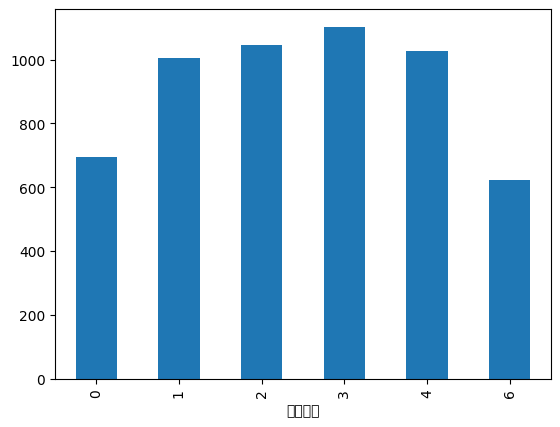

In [1882]:
member.groupby('위원회수').mean()['법안'].plot.bar()

많은 위원회에 참여한다고 해서 법안을 많이 내지는 않았다.